## Comparison of the diamond market in Israel and Italy

#### Introduction

The purpose of this analysis is to assess which high-cut diamonds of I and J colors were targeted at which markets.

This analysis can be useful when a diamond distributor receives a large consignment of high-cut I and J color diamonds with varying clarity grades. When store managers in Israel and Italy want to import these diamonds into their warehouses, the question arises: which stores should they entrust these diamonds to for sale? This analysis will answer this question.

In addition, the analysis includes an introductory section presenting a general analysis of the diamond market in Israel and Italy.

#### 1. Loading libraries and data

In [87]:
library(SparkR)
library(ggplot2)
library(dplyr)
library(tidyr)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 89, Finished, Available, Finished)

##### 1.1. Loading tables

Tables from Lakehouse should be moved to the Spark data frame so that they can be executed in a distributed manner.

In [88]:
customers_df <- tableToDF("gold.dim_customers")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 90, Finished, Available, Finished)

The type of the received object should be checked. Only SparkDataFrame data frames can be processed distributedly. Data.frames or tibbles from the R language will not be processed distributedly - ​​they will be executed on the Spark control node.

In [89]:
class(customers_df)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 91, Finished, Available, Finished)

[1] "SparkDataFrame"
attr(,"package")
[1] "SparkR"

Now that you are sure that the tableToDF function returns a SparkDataFrame and not a regular data.frame or tibble, you can move the remaining tables to SparkDataFrame

In [90]:
time_df <- tableToDF("gold.dim_time")
diamonds_df <- tableToDF("gold.dim_diamonds")
countries_df <- tableToDF("gold.dim_countries")
tranactions_df <- tableToDF("gold.fact_transactions")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 92, Finished, Available, Finished)

##### 1.2 Obtaining data about the country in which the transaction was concluded

Next, the transaction fact is linked to the customers dimension to retrieve customer data for each transaction. This will later help retrieve data about the country in which the transaction took place.

In [91]:
tranactions_df_country <- join(tranactions_df, customers_df, 
                                tranactions_df$customer_id == customers_df$customer_id , 
                                joinType = "left_outer")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 93, Finished, Available, Finished)

The results are checked with the display function

In [92]:
display(tranactions_df_country)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 94, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 5b231d8b-af39-46c3-8545-34f3db93077e)

Once you have added customer information including the customer's country ID, you can perform another join with the countries table to retrieve the relevant information about individual countries.Data inspection is performed using the display function.

In [93]:
tranactions_df_country <- join(tranactions_df_country, countries_df, tranactions_df_country$country_id == countries_df$country_id, joinType = "left_outer")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 95, Finished, Available, Finished)

In [94]:
display(tranactions_df_country)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 96, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, dfab2086-dfd1-4e74-b062-c2b333c55ef7)

It is clear that the country information has been successfully added to the table

To limit the number of columns to those necessary, the SparkR::select function will be used

In [95]:
tranactions_df_country_filtered <- SparkR::select(
  tranactions_df_country,
  "transaction_id", "diamond_id", "quantity", "total_price", 
  "country", "date_id", "region"                  
)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 97, Finished, Available, Finished)

In [96]:
display(tranactions_df_country_filtered)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 98, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 803f2ff3-4596-4851-b258-cf6c997c28be)

#### 1.3. Analysis of the regions in which Israel and Italy are located

Transactions are grouped by region, which will help calculate aggregations by region later.

In [97]:
tranactions_df_groupped_region <- groupBy(tranactions_df_country_filtered, "region")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 99, Finished, Available, Finished)

For each region, the total transaction amount is calculated

In [98]:
tranactions_df_summary_region <- SparkR::summarize(
  tranactions_df_groupped_region,
  transactions_sum = sum(column("total_price"))
)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 100, Finished, Available, Finished)

It is possible to display sales data by region in the form of a clear table

In [99]:
display(tranactions_df_summary_region)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 101, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 10ba3813-f72b-4d7a-b2da-89f42c5b4d3e)

For visualization, data stored in SparkDataFrame should be transformed into data.frame or tibble from R language

In [100]:
df_display <- SparkR::collect(tranactions_df_summary_region)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 102, Finished, Available, Finished)

After converting to a standard data.frame from R, it is worth familiarizing yourself with the structure of the resulting data.

In [101]:
str(df_display)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 103, Finished, Available, Finished)

'data.frame':	7 obs. of  2 variables:
 $ region          : chr  "South Asia" "Middle East, North Africa, Afghanistan & Pakistan" "Sub-Saharan Africa" "Europe & Central Asia" ...
 $ transactions_sum: num  3.00e+07 4.32e+07 1.50e+07 2.90e+08 2.31e+08 ...

It is clear that the region is of type chr, which is not conducive to further analysis. To convert the data from chr to factor with the appropriate levels, use the reorder/ function

In [102]:
df_display <- df_display %>%
    mutate(region = reorder(region, -transactions_sum))

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 104, Finished, Available, Finished)

After converting the region column to factor, you can easily display the income of the regions in a column chart.

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 105, Finished, Available, Finished)

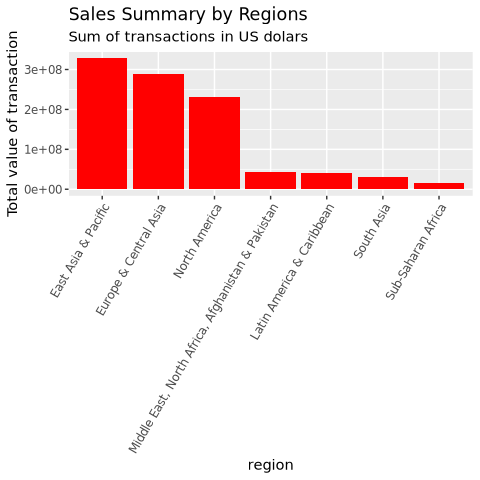

In [103]:
ggplot(df_display, aes(x = region, y = transactions_sum))+
    geom_col(fill= "red")+
    theme(axis.text.x = element_text(angle = 60, hjust = 1))+
    labs(
        title = "Sales Summary by Regions",
        subtitle= "Sum of transactions in US dolars",
        y = "Total value of transaction"
    )

The regions of interest for this analysis are the Middle East and Europe, as these regions include the countries under analysis—Italy and Israel. It's clear that sales in the Middle East, where Israel is located, are significantly lower than sales in Europe. This may mean that diamonds are better shipped to Europe for faster sales. However, a regional analysis alone doesn't allow for such a decision—a more in-depth analysis is required.

#### 2. Sales analysis in the Middle East region

In order to analyze diamond sales in the Middle East region, transactions must be filtered.

In [104]:
tranactions_df_middle_east <- SparkR::where(tranactions_df_country_filtered, tranactions_df_country_filtered$region == "Middle East, North Africa, Afghanistan & Pakistan")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 106, Finished, Available, Finished)

To find out sales in individual countries in this region, group the tables by country.

In [105]:
tranactions_df_country_middle_east_group <- groupBy(tranactions_df_middle_east, "country")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 107, Finished, Available, Finished)

Total sales for each country in the Middle East region are then added up.

In [106]:
tranactions_df_middle_east_sales <- SparkR::summarize(
  tranactions_df_country_middle_east_group,
  transactions_sum = sum(column("total_price"))
)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 108, Finished, Available, Finished)

In [107]:
display(tranactions_df_middle_east_sales)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 109, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 69d3dc82-0802-45fc-bcaa-5b97625921d0)

Then it is converted to a regular data.frame from R.

In [108]:
df_d_middle_east <- SparkR::collect(tranactions_df_middle_east_sales)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 110, Finished, Available, Finished)

This is followed by the five countries with the highest diamond sales in the Middle East region.

In [109]:
df_d_middle_east_sorted <- df_d_middle_east %>%
    mutate(country = reorder(country, -transactions_sum)) %>%
    arrange(desc(transactions_sum)) %>%
    head(5)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 111, Finished, Available, Finished)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 112, Finished, Available, Finished)

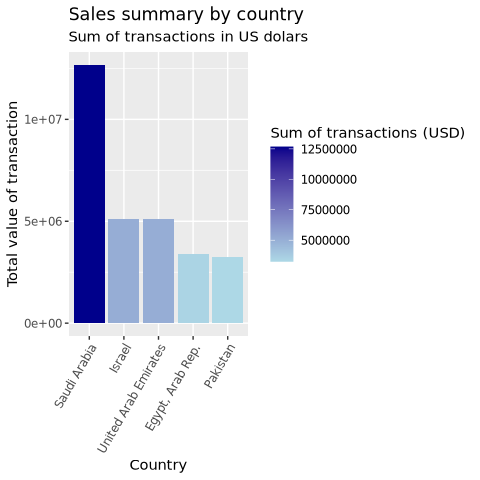

In [110]:
ggplot(df_d_middle_east_sorted, aes(x = country, y = transactions_sum, fill = transactions_sum))+
    geom_col()+
    theme(axis.text.x = element_text(angle = 60, hjust = 1))+
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
        title = "Sales summary by country",
        subtitle= "Sum of transactions in US dolars",
        y = "Total value of transaction",
        x = "Country",
        fill = "Sum of transactions (USD)"
    )



Israel is one of the most important recipients in this region, ranking second. Therefore, the Middle East is a significant market for diamonds.

#### 3. Sales analysis in the Europe region

Following the same procedure as for the Middle East, diamond sales statistics for Europe were obtained.

In [111]:
transactions_summary_eu <- SparkR::where(tranactions_df_country_filtered, tranactions_df_country_filtered$region == "Europe & Central Asia")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 113, Finished, Available, Finished)

In [112]:
tranactions_df_country_europe_group <- groupBy(transactions_summary_eu, "country")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 114, Finished, Available, Finished)

In [113]:
tranactions_df_summary_region_eu <- SparkR::summarize(
tranactions_df_country_europe_group,
  transactions_sum = sum(column("total_price"))
)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 115, Finished, Available, Finished)

In [114]:
display_europe_sales <- SparkR::collect(tranactions_df_summary_region_eu)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 116, Finished, Available, Finished)

In [115]:
display_europe_sales_sorted <-display_europe_sales %>%
    mutate(country = reorder(country, -transactions_sum)) %>%
    arrange(desc(transactions_sum)) %>%
    head(5)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 117, Finished, Available, Finished)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 118, Finished, Available, Finished)

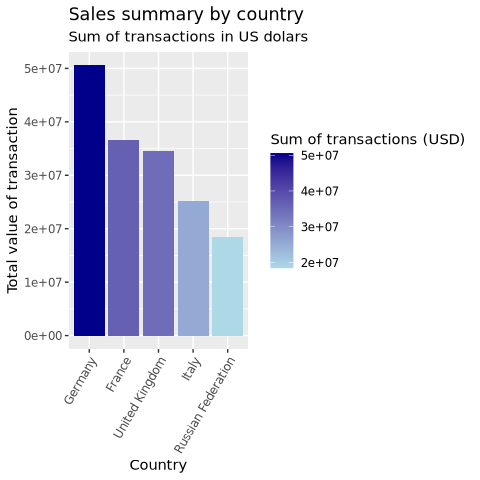

In [116]:
ggplot(display_europe_sales_sorted, aes(x = country, y = transactions_sum, fill = transactions_sum))+
    geom_col()+
    theme(axis.text.x = element_text(angle = 60, hjust = 1))+
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
        title = "Sales summary by country",
        subtitle= "Sum of transactions in US dolars",
        y = "Total value of transaction",
        x = "Country",
        fill = "Sum of transactions (USD)"
    )

Based on the chart, it can be concluded that Italy is also an important diamond market in the European region - it is in fourth place, but with a very high level of sales compared to Israel.

#### 4. Comparison of the diamond market value in Israel and Italy

In order to more easily assess how the value of diamond sales differs in Italy and Israel, a dedicated chart has been developed to easily assess this difference.

In [117]:
display_israel_italy_compare_all_diamonds_value <-display_europe_sales_sorted %>%
    bind_rows(df_d_middle_east_sorted) %>%
    filter(country %in% c("Italy", "Israel"))
    

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 119, Finished, Available, Finished)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 120, Finished, Available, Finished)

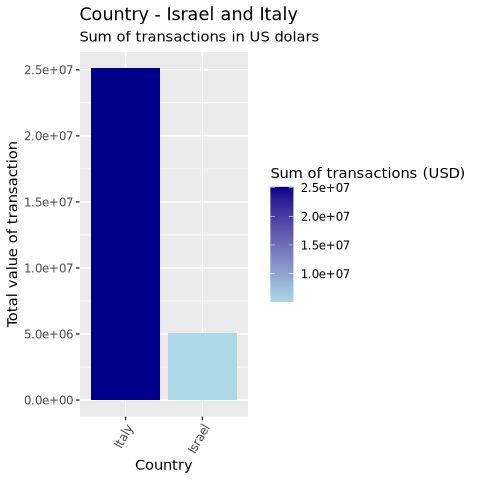

In [118]:
ggplot(display_israel_italy_compare_all_diamonds_value, aes(x = country, y = transactions_sum, fill = transactions_sum))+
    geom_col()+
    theme(axis.text.x = element_text(angle = 60, hjust = 1))+
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
        title = "Country - Israel and Italy",
        subtitle= "Sum of transactions in US dolars",
        y = "Total value of transaction",
        x = "Country",
        fill = "Sum of transactions (USD)"
    )

It's clear that diamond sales in Italy are significantly higher than in Israel. The new batch of diamonds should be sent to a distributor in Italy—but is that really the case? A more detailed analysis might reveal that not all diamonds in the new batch should necessarily be sent to Italy.

#### 5. The market for heavy I, J-color and premium, ideal-cut diamonds

This section will assess the market for high-cut I and J-color diamonds in both Israel and Italy. Before doing so, the data must be transformed to provide meaningful insights.

First, a subset of the diamond set must be created containing only those features that are known for the new batch of diamonds.

In [119]:
diamonds_df_selected <- diamonds_df %>%
    SparkR::select("diamond_id", "carat", "cut", "color", "clarity", "price")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 121, Finished, Available, Finished)

Then, using the left join, you need to supplement the transaction information with information about the diamond purchased in a given transaction.

In [120]:
tranactions_df_diamonds <- join(tranactions_df_country_filtered,
                                 diamonds_df_selected , 
                                 tranactions_df_country_filtered$diamond_id == diamonds_df_selected$diamond_id , 
                                 joinType = "left_outer")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 122, Finished, Available, Finished)

In [121]:
display(tranactions_df_diamonds)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 123, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 041bc3f1-beab-4c7f-9603-b77fe7f90e4d)

It is clearly visible that the collection has been enriched with information about diamonds, which will allow for a more detailed analysis.

##### 5.1. Isreal

A universal function has been written to obtain the number of diamonds sold.

In [122]:
plot_diamonds_by_country <- function(df, country_name) {

  df_country <- SparkR::where(df, df$country == country_name)
  
  df_group <- groupBy(df_country, "color", "cut")
  df_summary <- SparkR::summarize(
    df_group,
    number_of = SparkR::count(column("transaction_id"))
  )
  
  df_local <- SparkR::collect(df_summary)
  
  df_local <- df_local %>%
    mutate(across(where(is.character), as.factor)) %>%
    complete(cut, color, fill = list(number_of = 0))
  
  df_local$cut <- factor(
    df_local$cut,
    levels = c("Fair", "Good", "Very Good", "Premium", "Ideal"),
    ordered = TRUE
  )
  
  ggplot(df_local, aes(x = color, y = cut, fill = number_of)) +
    geom_tile(color = "white") +
    labs(
      title = paste("Number of I/J high cut class diamonds sold in", country_name),
      subtitle = "By cut and color",
      y = "Cut class",
      x = "Color class",
      fill = "Number of sold"
    ) +
    theme_minimal()
}

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 124, Finished, Available, Finished)

Call of this function:

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 125, Finished, Available, Finished)

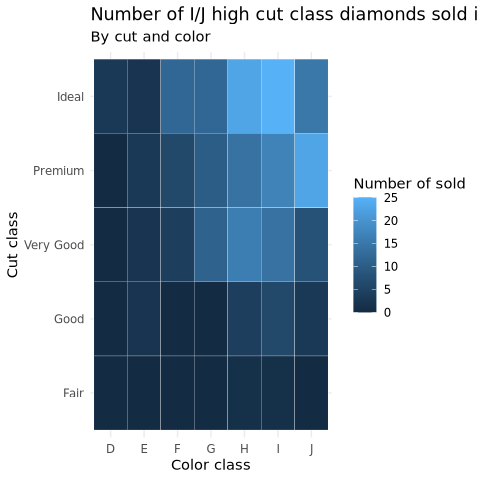

In [123]:
plot_diamonds_by_country(tranactions_df_diamonds, "Israel")

It's clear that grade I and J diamonds with high cut quality are selling well in Israel compared to other diamonds. Therefore, it's worth exploring this market more closely, as it might be worthwhile to send some of the new batch of grade I and J diamonds with high cut quality to Israel.

##### 5.2. Italy

Using a similar method as in the case of Israel, a graph was obtained showing the number of diamonds sold in Italy depending on the class of cut and color.

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 126, Finished, Available, Finished)

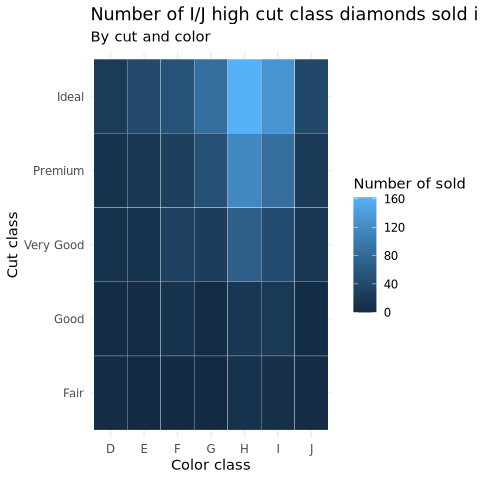

In [124]:
plot_diamonds_by_country(tranactions_df_diamonds, "Italy")

It's clear that there's a similar trend to Israel—many high-quality cut diamonds are being sold. But there's a difference: in Italy, the percentage of J-color diamonds isn't as high as in Israel.

#### 7. Prices and sales time of diamonds in Israel

Before extract data about sales, lets prepare joined data to be futher processed

##### 7.1 Preparing data

In order to analyze time - how many diamonds are sold at what time - it is necessary to select intervening time units from time_df.

In [125]:
time_df_selected <-time_df %>%
    SparkR::select("date_id", "year", "month")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 127, Finished, Available, Finished)

In order to avoid repeating names in later merges, the table names are changed

In [126]:
time_df_selected <- SparkR::withColumnRenamed(time_df_selected, "date_id", "date_id_time")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 128, Finished, Available, Finished)

In the original dataset, there is a duplicate diamond id in the second and eighth columns. This duplication should be removed.

In [127]:
cols <- colnames(tranactions_df_diamonds)

cols_to_keep <- cols[-c(2, 8)]

tranactions_df_diamonds <- SparkR::select(tranactions_df_diamonds, cols_to_keep)


StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 129, Finished, Available, Finished)

After removing existing column duplications, you can add information about the transaction time to the transaction table.

In [128]:
tranactions_df_diamonds_date <- SparkR::join(tranactions_df_diamonds, time_df_selected,tranactions_df_diamonds$date_id == time_df_selected$date_id_time, joinType = "left_outer")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 130, Finished, Available, Finished)

##### 7.2 Analysis of monthly sale in Israel

A universal function has been created to prepare data and display sales in individual months.

In [129]:
plot_sales_time_by_country <- function(df, country_name) {

  df_country <- SparkR::where(
    df,
    df$country == country_name &
      df$carat > 1 &
      df$color %in% c("I", "J") &
      df$cut %in% c("Premium", "Ideal")
  )
  
  df_local <- SparkR::collect(df_country)
  
  df_local <- df_local %>%
    mutate(across(where(is.character), as.factor)) %>%
    mutate(
      clarity = factor(
        clarity,
        levels = c("I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"),
        ordered = TRUE
      )
    )
  
  df_sum <- df_local %>%
    group_by(month) %>%
    summarise(total_sale = sum(total_price)) %>%
    ungroup() %>%
    mutate(month = factor(month, ordered = TRUE))
  
  ggplot(df_sum, aes(x = month, y = total_sale)) +
    geom_col(fill = "#2C7BB6") +
    labs(
      title = paste("Total sale value of I/J high class cut in", country_name),
      subtitle = "By month",
      y = "Sale value",
      x = "Month"
    ) +
    theme_minimal()
}

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 131, Finished, Available, Finished)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 132, Finished, Available, Finished)

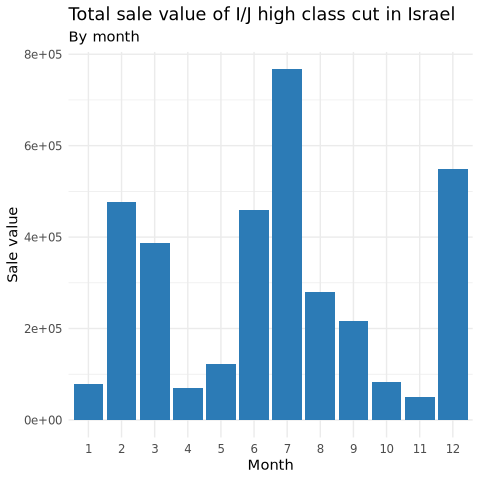

In [130]:
plot_sales_time_by_country(tranactions_df_diamonds_date, "Israel")

It can be seen that at the end of winter/beginning of spring and in December, as well as in summer, sales of diamonds with colors I and J and high clarity class are the highest.

#### 8. Prices and sales time of diamonds in Italy

Following the same procedure as in the case of Israel, a chart of sales of diamonds with colors I and J and high cut class in individual months in Italy is obtained.

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 133, Finished, Available, Finished)

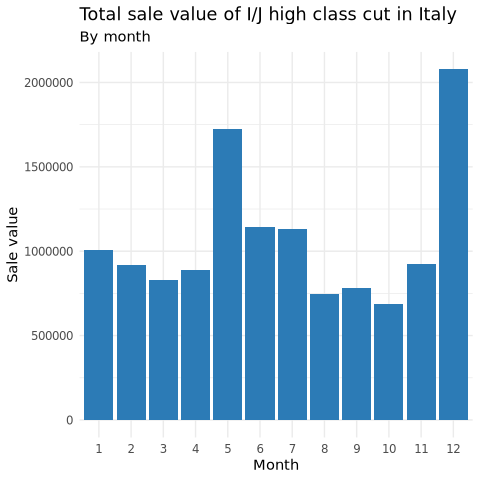

In [131]:
plot_sales_time_by_country(tranactions_df_diamonds_date, "Italy")

It's clear that sales of diamonds with colors I and J and high cut grades are particularly high in Italy in May and December. Sales are similar in other months, with the exception of June and July, where they are higher than average, but decline significantly in August.

#### 9. Comparassion of mounthly slaes in Israel and Italy

It is advisable to compare the sales of diamonds of interest in the analysis in individual months both in Italy and in Israel.

In order to obtain the necessary data, appropriate modifications must be performed.

In [132]:
display_israel_sum_data <- display_israel_sales_time_sum %>%
    mutate(country = "Israel") 

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 134, Finished, Available, Finished)

In [133]:
display_italy_sum_data <- display_month_italy_plot_data %>%
    mutate(country = "Italy")

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 135, Finished, Available, Finished)

We then combine the table rows containing data for Italy and Israel.

In [134]:
display_italy_israel_data <- display_israel_sum_data %>%
    bind_rows(display_italy_sum_data)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 136, Finished, Available, Finished)

Once data is organized, you can easily display it.

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 137, Finished, Available, Finished)

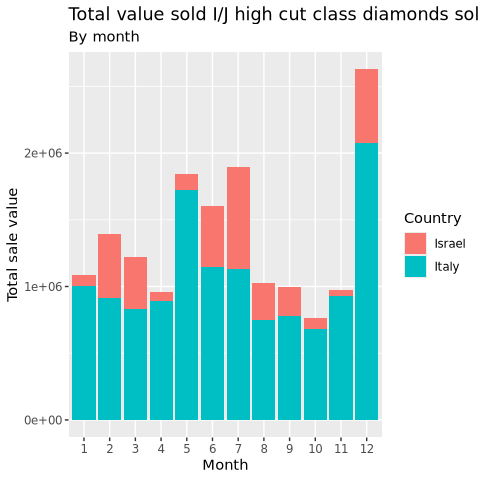

In [135]:
ggplot(display_italy_israel_data, aes( x= month, y = total_sale, fill = country))+
    geom_col()+
    labs(
        title = "Total value sold I/J high cut class diamonds sold in Israel and Italy",
        subtitle= "By month",
        y = "Total sale value",
        x = "Month",
        fill = "Country"
    ) 

The chart clearly shows that overall sales of high-cut class, color I and J diamonds are typically higher in Italy, but sometimes sales levels in Israel approach those in Italy—for example, in July. 

#### 10. Sales analysis of color I and J diamonds with a high cut class depending on clarity.

It's advisable to analyze the sales of I/J/high-cut diamonds of specific clarity grades by month. This will provide management with the necessary information about which months to ship I/J/high-cut diamonds to which countries.

##### 10.1. Sales of I/J high class cut diamonds in Israel by month and purity

To obtain this statistic, grouping and summing is performed across individual months and clarity classes - all in universal function

In [136]:
plot_month_clarity_heatmap <- function(df, country_name) {

  df_plot <- df %>%
    group_by(month, clarity) %>%
    summarise(total_sale = sum(total_price), .groups = "drop") %>%
    mutate(month = factor(month, ordered = TRUE))
  
  df_plot <- df_plot %>%
    complete(month, clarity, fill = list(total_sale = 0))
  
  ggplot(df_plot, aes(x = month, y = clarity, fill = total_sale)) +
    geom_raster() +
    labs(
      title = paste("I/J high cut class diamonds sold in", country_name),
      subtitle = "By month and clarity",
      y = "Clarity class",
      x = "Month",
      fill = "Total value (USD)"
    ) +
    theme_minimal()
}

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 138, Finished, Available, Finished)

Appropriate data was collected to display a graph showing the dependence of the value of sold high-cut color I and J diamonds on their clarity and the month of sale.

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 139, Finished, Available, Finished)

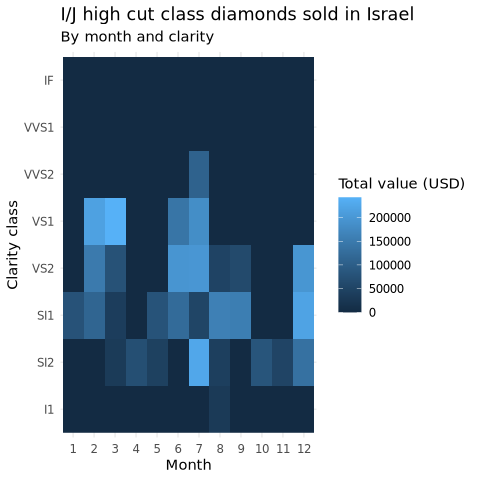

In [137]:
plot_month_clarity_heatmap(display_israel_sales_time, "Israel")

The chart shows that sales of I/J high-cut diamonds in Israel vary by month, both in terms of the number of diamonds sold and the popularity of diamonds with a given clarity. While SI1 clarity diamonds sell moderately year-round, VS clarity diamonds sell well only at the turn of winter and spring, and at the turn of spring and summer.

##### 10.1. Sales of I/J high class cut diamonds in Italy by month and purity

By proceeding in a similar manner as in Israel, an appropriate graph is obtained.

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 140, Finished, Available, Finished)

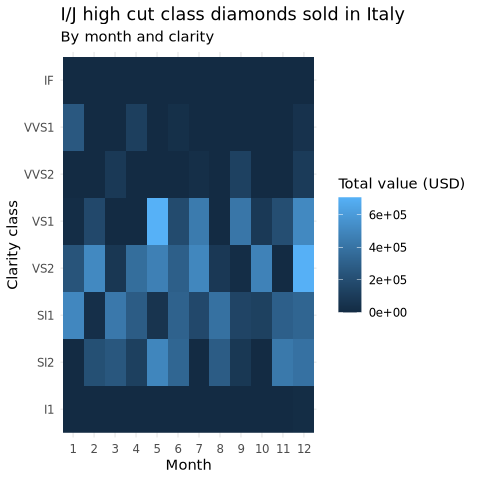

In [138]:
plot_month_clarity_heatmap(display_italy_sales_time, "Italy")

It is clear that the sale of I/J/high class cut diamonds of a certain purity in Italy can be completely different from that in Israel.

##### 10.3. Sales ratio of I/J high class cut diamonds with a specific clarity in Israel and Italy

To determine which high-class cut diamonds of a given clarity sell better in Italy and which in Israel, in which month you should connect the tables with columns - those concerning sales in Italy and those in Israel.

In [139]:
display_month_plot_data_italy_end <- display_month_italy_plot_data %>%
    rename(total_sale_italy = total_sale) %>%
    select(total_sale_italy)


StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 141, Finished, Available, Finished)

In [140]:
display_month_plot_data_italy_end_israel <- display_month_israel_plot_data %>%
    bind_cols(display_month_plot_data_italy_end)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 142, Finished, Available, Finished)

Then calculate the proportion taking into account the elimination of division by zero.

In [141]:
display_month_plot_data_italy_end_israel_prop <- display_month_plot_data_italy_end_israel %>%
    mutate(proportion = ifelse(total_sale_italy == 0, 0, total_sale/total_sale_italy))

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 143, Finished, Available, Finished)

It is possible now to view a chart of the sales ratio of I/J high class cut diamonds in Italy and Israel.

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 144, Finished, Available, Finished)

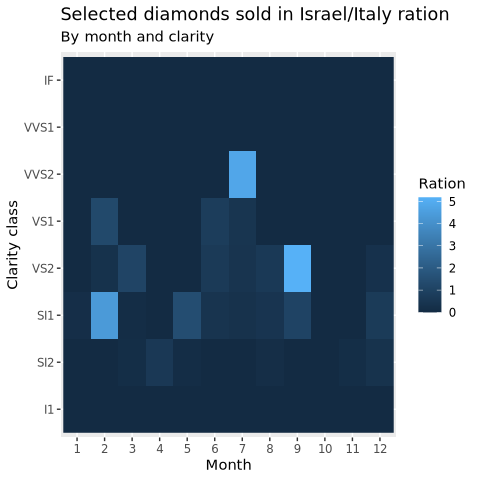

In [142]:
ggplot(display_month_plot_data_italy_end_israel_prop, aes(x = month, y = clarity, fill = proportion))+
    geom_raster()+
    labs(
        title = "Selected diamonds sold in Israel/Italy ration",
        subtitle= "By month and clarity",
        y = "Clarity class",
        x = "Month",
        fill = "Ration"
    ) 

It's clear that sales of high-class I/J cut diamonds of a given clarity in Israel are sometimes significantly higher than comparable sales in Italy. Therefore, most diamonds from the new batch should be sent to Israel, but some diamonds from the new batch should be sent to Israel instead of Italy in certain months, as there's a higher probability of sales there.

Another chart will be drawn up to determine in which specific months I/J high class cut diamonds of which specific clarity should be sent not to Italy but to Israel.

Modifying the dataset to include information about increased sales in Israel.

In [143]:
display_advatage_israel <- display_month_plot_data_italy_end_israel_prop %>%
    mutate(decision = case_when(
        1<proportion ~ TRUE,
        1>proportion ~ FALSE,
    )) %>%
    mutate(decision = factor(decision, ordered = TRUE))

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 145, Finished, Available, Finished)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 146, Finished, Available, Finished)

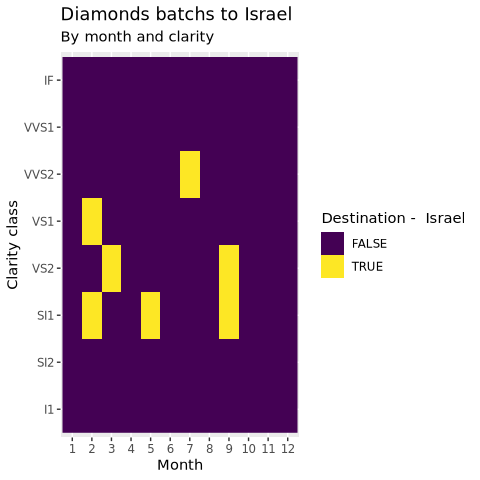

In [144]:
ggplot(display_advatage_israel, aes(x = month, y = clarity, fill = decision))+
    geom_raster()+
    labs(
        title = "Diamonds batchs to Israel",
        subtitle= "By month and clarity",
        y = "Clarity class",
        x = "Month",
        fill = "Destination -  Israel"
    ) 

To summarize the above chart showing Israel's advantage over Italy in the sale of I/J high-class cut diamonds, it's clear that SI1 and VS1 clarity diamonds are better sent to Israel in February. VS2 clarity diamonds are also better sent to Israel in March. In May, SI1 clarity diamonds should be sent to Israel. In July, VVS2 clarity diamonds should be sent to Israel, and in September, SI1 and VS2 clarity diamonds.

##### 10.4 Difference in sales volume of selected diamonds in selected months

In the previous chapter, we selected diamond clarity grades, which should indicate which I/J high-class cut diamonds should be shipped to Israel. This subsection will allow us to estimate the differences in the sales of these diamonds in both countries to visualize this difference.

First, the positions where Israel had the advantage are indicated.

In [145]:
display_israel_italy_sum <- display_advatage_israel %>%
    filter(decision == TRUE)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 147, Finished, Available, Finished)

Then a tibble is created with the results

In [146]:
tibble_summary <- tibble(
    country = c("Italy", "Israel"),
    sale_total = c(sum(display_israel_italy_sum$total_sale_italy),sum(display_israel_italy_sum$total_sale))
)

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 148, Finished, Available, Finished)

All data is now complete, the chart can be displayed.

StatementMeta(, d489f68d-6f68-403d-a3f0-ca17a85bd774, 149, Finished, Available, Finished)

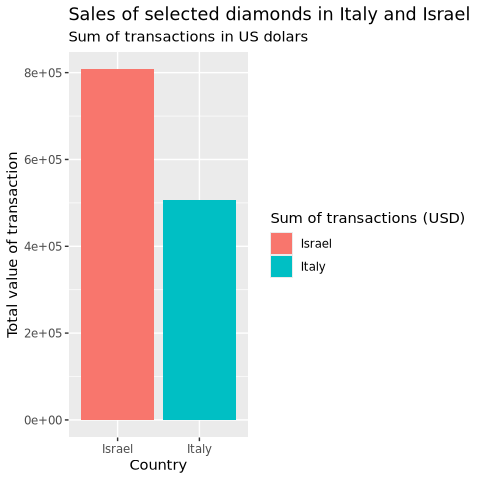

In [147]:
ggplot(tibble_summary, aes( x = country, y = sale_total, fill = country))+
    geom_col()+
    labs(
        title = "Sales of selected diamonds in Italy and Israel",
        subtitle= "Sum of transactions in US dolars",
        y = "Total value of transaction",
        x = "Country",
        fill = "Sum of transactions (USD)"
    )

It is clearly visible that the difference in sales of I/J high class cut diamonds with selected purities and in selected months is significantly greater in favor of Israel - by about 40%.

#### 11. Summary

The most important summary of this study is defined by the previously developed conclusion:

_To summarize the above chart showing Israel's advantage over Italy in the sale of I/J high-class cut diamonds, it's clear that SI1 and VS1 clarity diamonds are better sent to Israel in February. VS2 clarity diamonds are also better sent to Israel in March. In May, SI1 clarity diamonds should be sent to Israel. In July, VVS2 clarity diamonds should be sent to Israel, and in September, SI1 and VS2 clarity diamonds_

Indeed, despite significantly lower sales of all diamond types in Israel than in Italy, some diamonds should be considered for entrusting to an Israeli distributor. Most diamonds in Italy are indeed likely to sell faster, but as mentioned, this is not always the case.

It is worth noting that due to the small number of transactions in Italy, and especially in Israel, compared to the US or China, the above conclusions are less certain than in the case of much larger markets.

It is also worth noting that the diamond markets in Israel and Italy exhibit interesting similarities – both in terms of customers' preference for high-quality cuts and H-J colors – there are differences here, but mainly in the details. However, they differ in their preferences regarding the timing of purchasing these diamonds – details can be found in the study. However, there are certain similarities in this regard – in both countries, sales are higher in December. However, there are large differences in the scope when I/J high class cut diamonds with a specific clarity are purchased - which is described in the conclusion quoted earlier in italics.
